In [2]:
import sys
from pathlib import Path

# add project root (one level up from notebooks/) to sys.path
ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))


In [3]:
from src.data.loaders import load_national_ae_timeseries
from src.features.build_features import build_feature_table


In [4]:
from pathlib import Path
import pandas as pd
from src.data.loaders import load_national_ae_timeseries
from src.features.build_features import build_feature_table

RAW = Path("../data/raw/ae_timeseries.csv")
PROC_DIR = Path("../data/processed")
PROC_DIR.mkdir(parents=True, exist_ok=True)

ts = load_national_ae_timeseries(RAW)
ts.to_csv(PROC_DIR / "ae_timeseries_clean.csv", index=False)

feat = build_feature_table(ts)
feat.to_csv(PROC_DIR / "ae_features.csv", index=False)

print("Saved:",
      (PROC_DIR / "ae_timeseries_clean.csv").as_posix(),
      (PROC_DIR / "ae_features.csv").as_posix(), sep="\n")
feat.tail()


Saved:
../data/processed/ae_timeseries_clean.csv
../data/processed/ae_features.csv


,Date,y,year,month,quarter,month_sin,month_cos,lag_1,lag_2,lag_3,lag_12,roll3_mean,roll6_mean,roll12_mean,roll3_std,roll6_std,roll12_std,mom_1,mom_yoy,has_public_holiday
163,2025-03-01,2389064,2025,3,1,1.000000e+00,6.123234e-17,2088071.0,2218130.0,2345934.0,2370221.0,2.217378e+06,2.256981e+06,2.279063e+06,128933.143312,103798.838645,96163.008217,0.144149,0.007950,0
164,2025-04-01,2295820,2025,4,2,8.660254e-01,-5.000000e-01,2389064.0,2088071.0,2218130.0,2240668.0,2.231755e+06,2.286122e+06,2.280633e+06,150958.361746,113483.838625,97924.562616,-0.039030,0.024614,0
165,2025-05-01,2395886,2025,5,2,5.000000e-01,-8.660254e-01,2295820.0,2389064.0,2088071.0,2416292.0,2.257652e+06,2.275336e+06,2.285229e+06,154083.784885,107936.565397,97169.657800,0.043586,-0.008445,0
166,2025-06-01,2350478,2025,6,2,1.224647e-16,-1.000000e+00,2395886.0,2295820.0,2389064.0,2294065.0,2.360257e+06,2.288818e+06,2.283529e+06,55907.941559,118423.168300,94817.592560,-0.018952,0.024591,0
167,2025-07-01,2407884,2025,7,3,-5.000000e-01,-8.660254e-01,2350478.0,2395886.0,2295820.0,2324832.0,2.347395e+06,2.289575e+06,2.288230e+06,50104.204388,118875.157469,96765.945901,0.024423,0.035724,0


In [5]:
import numpy as np

# Seasonal naive: predict this month = value from 12 months ago
df = ts.copy()
df["y_hat_seasonal_naive"] = df["y"].shift(12)

# Train/validation split: hold out the last 12 months as validation
holdout = 12
train = df.iloc[:-holdout].copy()
valid = df.iloc[-holdout:].copy()

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

# Compute baseline ONLY where we have a 12-month lag
valid_bl = valid.dropna(subset=["y_hat_seasonal_naive"]).copy()

baseline_mape = mape(valid_bl["y"], valid_bl["y_hat_seasonal_naive"])
baseline_rmse = rmse(valid_bl["y"], valid_bl["y_hat_seasonal_naive"])

print(f"Baseline (Seasonal Naive) — MAPE: {baseline_mape:.2f}%, RMSE: {baseline_rmse:,.0f}")


Baseline (Seasonal Naive) — MAPE: 3.10%, RMSE: 86,447


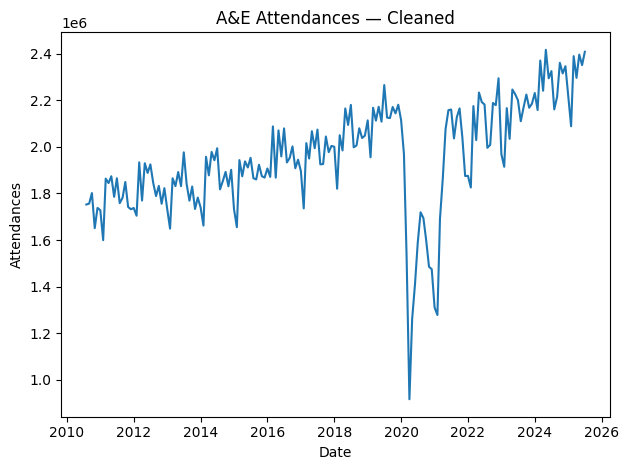

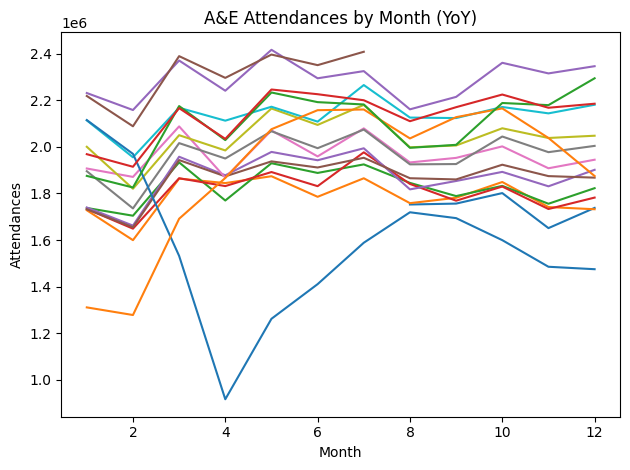

In [8]:
import matplotlib.pyplot as plt

# Level plot
plt.figure()
plt.plot(ts["Date"], ts["y"])
plt.title("A&E Attendances — Cleaned")
plt.xlabel("Date"); plt.ylabel("Attendances"); plt.tight_layout(); plt.show()

# Year-over-year by month
tmp = ts.copy()
tmp["year"] = tmp["Date"].dt.year
tmp["month"] = tmp["Date"].dt.month
pivot = tmp.pivot(index="month", columns="year", values="y")
pivot.plot(legend=False, title="A&E Attendances by Month (YoY)")
plt.xlabel("Month"); plt.ylabel("Attendances"); plt.tight_layout(); plt.show()
